# Brain Tumor MRI Classification with CNN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [3]:
# Images are 512x512 by default.
# Tried 3 channels vs 1, but found no significant difference.
# Decided to use 1 channel for simpler computation.
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

In [4]:
train_dataset = datasets.ImageFolder(root='Training/', transform=transform)
test_dataset = datasets.ImageFolder(root='Testing/', transform=transform)

In [5]:
cancer_names = {idx: name for idx, name in enumerate(train_dataset.classes)}
cancer_names

{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

In [6]:
image, label = train_dataset[0]
image.shape

torch.Size([1, 512, 512])

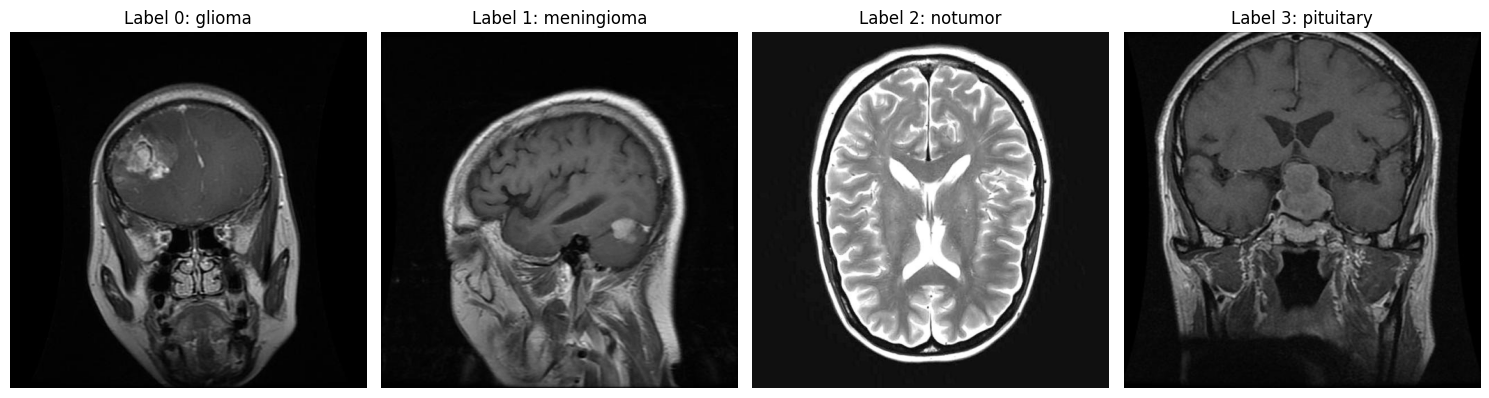

In [7]:
# Sample Images from Different Labels
indices = [0, 2000, 4000, 5000]
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for ax, idx in zip(axs, indices):
    image, label = train_dataset[idx]
    ax.imshow(image.cpu().numpy()[0], cmap='gray')
    ax.set_title(f'Label {label}: {cancer_names[label]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32, shuffle=False)

## Convolutional Neural Network (CNN)

### Convolution Output Formula

The formula to calculate the output dimensions after a convolution layer is:

$$
\text{Output Height} = \left( \frac{\text{Input Height} - \text{Kernel Height} + 2 \times \text{Padding}}{\text{Stride}} \right) + 1
$$

### Max Pooling Output Formula

The formula for calculating the output dimensions after a max pooling layer is:

$$
\text{Output Height} = \frac{\text{Input Height}}{\text{Kernel Size}}
$$

### Example Calculations

1. **First Convolution Layer (Block 1):**
   - **Input:** 512 x 512
   - **Kernel Size:** 3
   - **Padding:** 1
   - **Stride:** 1

   $$
   \text{Output Height} = \left( \frac{512 - 3 + 2 \times 1}{1} \right) + 1 = 512
   $$

2. **Second Convolution Layer (Block 1):**
   - **Input:** 512 x 512
   - **Kernel Size:** 3
   - **Padding:** 1
   - **Stride:** 1

   $$
   \text{Output Height} = \left( \frac{512 - 3 + 2 \times 1}{1} \right) + 1 = 512
   $$

3. **First Max Pooling Layer (Block 1):**
   - **Input:** 512 x 512
   - **Kernel Size:** 2

   $$
   \text{Output Height} = \frac{512}{2} = 256
   $$

4. **First Convolution Layer (Block 2):**
   - **Input:** 256 x 256
   - **Kernel Size:** 3
   - **Padding:** 1
   - **Stride:** 1

   $$
   \text{Output Height} = \left( \frac{256 - 3 + 2 \times 1}{1} \right) + 1 = 256
   $$

5. **Second Convolution Layer (Block 2):**
   - **Input:** 256 x 256
   - **Kernel Size:** 3
   - **Padding:** 1
   - **Stride:** 1

   $$
   \text{Output Height} = \left( \frac{256 - 3 + 2 \times 1}{1} \right) + 1 = 256
   $$

6. **Second Max Pooling Layer (Block 2):**
   - **Input:** 256 x 256
   - **Kernel Size:** 2

   $$
   \text{Output Height} = \frac{256}{2} = 128
   $$

After passing through both blocks, the dimensions are reduced to **20 x 128 x 128**.

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        
       
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=20 * 128 * 128, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=6)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x


In [10]:
torch.manual_seed(42)
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

## Training the Model

In [11]:
train_losses = []
test_losses = []


for epoch in range(10):
    model.train()
    running_loss = 0.0
    
    # The reason for using batches:
    # Sometimes show stochastic behavior, which can lead to global minima.
    # To store is much easier.
    # Just an optimization thing.
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    correct = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    accuracy = correct / len(test_dataset)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}')


Epoch 1, Train Loss: 0.7367, Test Loss: 0.5364, Test Accuracy: 0.7925
Epoch 2, Train Loss: 0.4148, Test Loss: 0.4793, Test Accuracy: 0.8268
Epoch 3, Train Loss: 0.2880, Test Loss: 0.3651, Test Accuracy: 0.8604
Epoch 4, Train Loss: 0.2069, Test Loss: 0.2546, Test Accuracy: 0.9062
Epoch 5, Train Loss: 0.1455, Test Loss: 0.2253, Test Accuracy: 0.9176
Epoch 6, Train Loss: 0.0911, Test Loss: 0.2264, Test Accuracy: 0.9321
Epoch 7, Train Loss: 0.0704, Test Loss: 0.2101, Test Accuracy: 0.9367
Epoch 8, Train Loss: 0.0399, Test Loss: 0.2075, Test Accuracy: 0.9352
Epoch 9, Train Loss: 0.0361, Test Loss: 0.1943, Test Accuracy: 0.9344
Epoch 10, Train Loss: 0.0154, Test Loss: 0.2241, Test Accuracy: 0.9413


## Loss Curves: Training vs Testing

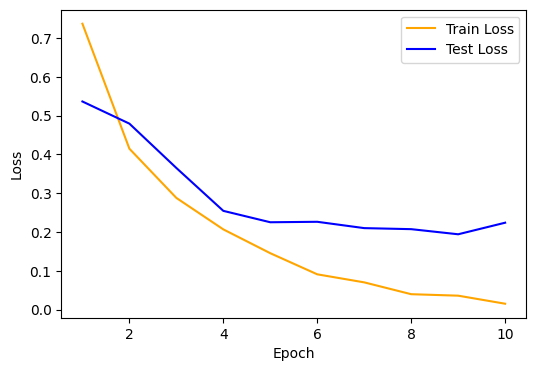

In [12]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, 11), train_losses, label='Train Loss', color='orange')
plt.plot(range(1, 11), test_losses, label='Test Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Model Evaluation: Checking Prediction Accuracy

Let’s see how well the model predicts the true labels in some random test images.

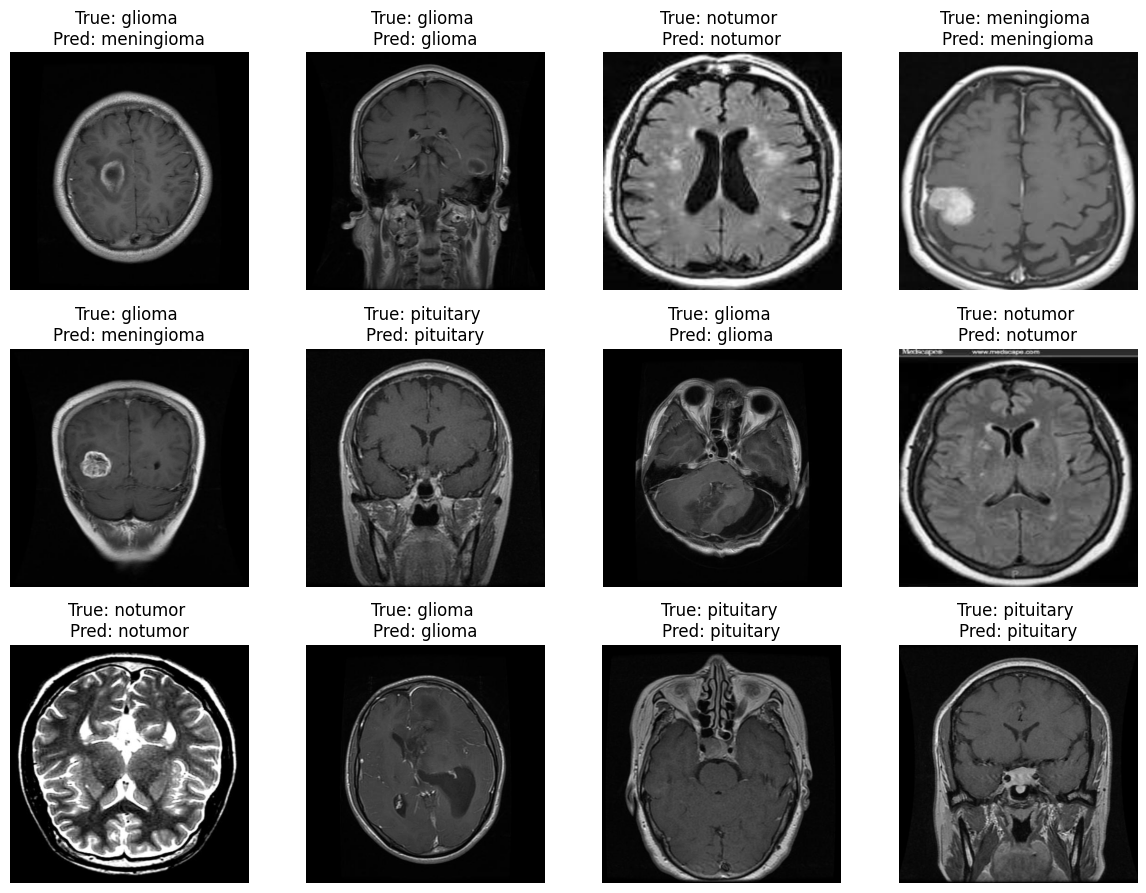

In [14]:
model.eval()

samples = random.sample(range(len(test_dataset)), 12)
sample_images = []
sample_labels = []
sample_preds = []

with torch.no_grad():
    for idx in samples:
        img, label = test_dataset[idx]
        img = img.unsqueeze(0).to(device)
        
        output = model(img)
        _, predicted = torch.max(output, 1)
        
        sample_images.append(img.cpu().numpy().squeeze())
        sample_labels.append(label)
        sample_preds.append(predicted.item())


plt.figure(figsize=(12, 12))
for i in range(12):
    plt.subplot(4, 4, i + 1)
    plt.imshow(sample_images[i], cmap='gray') 
    true_idx = sample_labels[i]
    pred_idx = sample_preds[i]
    plt.title(f'True: {cancer_names[true_idx]} \nPred: {cancer_names[pred_idx]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


## Conclusion

The evaluation shows the model accurately predicts most outcomes for this analysis.